In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
results_dir = os.path.join(
    cfg.repo_root, '03_cross_cancer_classification', 'results'
)
p53_results_dir = os.path.join(
    results_dir, 'p53_stability_pilot', 'cross_cancer'
)

In [3]:
cross_cancer_df = au.load_prediction_results_cc(p53_results_dir, 'cross_cancer')
print(cross_cancer_df.shape)
cross_cancer_df.head()

(3840, 8)


,auroc,aupr,train_identifier,test_identifier,signal,seed,data_type,experiment
0,0.97497,0.97336,TP53_LGG,TP53_LGG,signal,10,train,cross_cancer
1,0.97497,0.97336,TP53_LGG,TP53_LGG,signal,10,test,cross_cancer
2,0.96688,0.96759,TP53_LGG,TP53_LGG,signal,10,cv,cross_cancer
0,1.00000,1.00000,TP53_SARC,TP53_SARC,signal,3,train,cross_cancer
1,1.00000,1.00000,TP53_SARC,TP53_SARC,signal,3,test,cross_cancer


In [4]:
heatmap_df, sorted_ids = au.heatmap_from_results(cross_cancer_df,
                                                 normalize_control=True,
                                                 sort_results=False)
heatmap_df.iloc[:5, :5]

test_identifier,TP53_BLCA,TP53_BRCA,TP53_COAD,TP53_LGG,TP53_LUAD
train_identifier,,,,,
TP53_BLCA,0.468778,0.433715,0.274924,0.092554,0.300342
TP53_BRCA,0.260828,0.587076,0.218038,0.222713,0.285390
TP53_COAD,0.228648,0.249131,0.345130,0.096214,0.280085
TP53_LGG,0.185695,0.260923,0.129134,0.478854,0.199958
TP53_LUAD,0.287071,0.472707,0.252163,0.253624,0.487172


Text(115.0, 0.5, 'Train identifier')

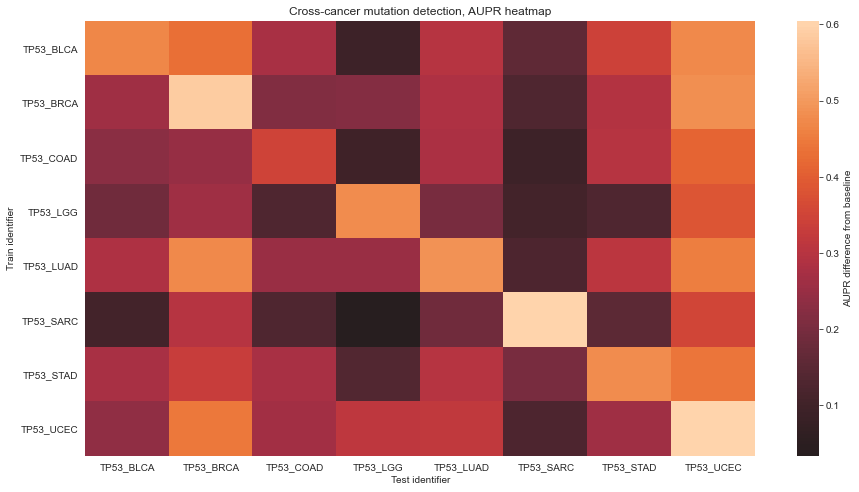

In [5]:
sns.set({'figure.figsize': (15, 8)})
sns.heatmap(heatmap_df, cbar_kws={'label': 'AUPR difference from baseline'}, center=0)
plt.title('Cross-cancer mutation detection, AUPR heatmap')
plt.xlabel('Test identifier')
plt.ylabel('Train identifier')

In [6]:
def get_valid_scores(results_dir):
    best_params_df = []
    for results_file in os.listdir(results_dir):
        if 'param_grid' not in results_file: continue
        if results_file[0] == '.': continue
        train_identifier = results_file.split('.')[0]
        test_identifier = results_file.split('.')[1]
        signal = results_file.split('.')[2].split('_')[0]
        seed = int(results_file.split('.')[2].split('_')[1].replace('s', ''))
        params_df = pd.read_csv(
            os.path.join(results_dir, results_file),
            sep='\t', index_col=['alpha', 'l1_ratio']
        )
        params_df.drop(columns=['Unnamed: 0'], inplace=True)
        best_params = (params_df
            .sort_values(by='mean_test_score', ascending=False)
            .head(1)
        )
        best_params['train_identifier'] = train_identifier
        best_params['test_identifier'] = test_identifier
        best_params['signal'] = signal
        best_params['seed'] = seed
        best_params_df.append(best_params.reset_index())
    return pd.concat(best_params_df).reset_index()

inner_results_df = get_valid_scores(p53_results_dir)
print(inner_results_df.shape)
inner_results_df.head()

(1280, 12)


,index,alpha,l1_ratio,fold,loss,penalty,mean_train_score,mean_test_score,train_identifier,test_identifier,signal,seed
0,0,0.01,0.50,-1,log,elasticnet,1.000000,0.555448,TP53_BLCA,TP53_SARC,shuffled,9
1,0,0.10,0.90,-1,log,elasticnet,0.378854,0.390230,TP53_BRCA,TP53_LUAD,shuffled,1
2,0,1.00,0.05,-1,log,elasticnet,0.833268,0.580104,TP53_BLCA,TP53_COAD,shuffled,7
3,0,0.10,0.30,-1,log,elasticnet,0.946812,0.884196,TP53_BRCA,TP53_BLCA,signal,8
4,0,0.10,1.00,-1,log,elasticnet,0.394052,0.370514,TP53_BRCA,TP53_BRCA,shuffled,10


In [7]:
plot_df = (inner_results_df
    .drop(columns=['index', 'alpha', 'l1_ratio', 'fold', 'loss', 'penalty', 'mean_train_score'])
    .rename(columns={'mean_test_score': 'aupr'})
)
plot_df['split'] = 'valid'
plot_df.head()

,aupr,train_identifier,test_identifier,signal,seed,split
0,0.555448,TP53_BLCA,TP53_SARC,shuffled,9,valid
1,0.390230,TP53_BRCA,TP53_LUAD,shuffled,1,valid
2,0.580104,TP53_BLCA,TP53_COAD,shuffled,7,valid
3,0.884196,TP53_BRCA,TP53_BLCA,signal,8,valid
4,0.370514,TP53_BRCA,TP53_BRCA,shuffled,10,valid


In [8]:
plot_big_df = pd.concat((
    plot_df,
    cross_cancer_df[cross_cancer_df.data_type == 'test']
      .drop(columns=['auroc', 'data_type', 'experiment'])
      .assign(split='test')
))
plot_big_df['identifiers'] = (
    plot_big_df.train_identifier + '/' + plot_big_df.test_identifier
)
plot_big_df = (
    plot_big_df[plot_big_df.signal == 'signal']
      .sort_values(by=['identifiers', 'split'], ascending=[True, False])
)
plot_big_df.head()

,aupr,train_identifier,test_identifier,signal,seed,split,identifiers
126,0.866300,TP53_BLCA,TP53_BLCA,signal,7,valid,TP53_BLCA/TP53_BLCA
195,0.869513,TP53_BLCA,TP53_BLCA,signal,6,valid,TP53_BLCA/TP53_BLCA
390,0.871243,TP53_BLCA,TP53_BLCA,signal,5,valid,TP53_BLCA/TP53_BLCA
397,0.865526,TP53_BLCA,TP53_BLCA,signal,1,valid,TP53_BLCA/TP53_BLCA
461,0.870198,TP53_BLCA,TP53_BLCA,signal,10,valid,TP53_BLCA/TP53_BLCA


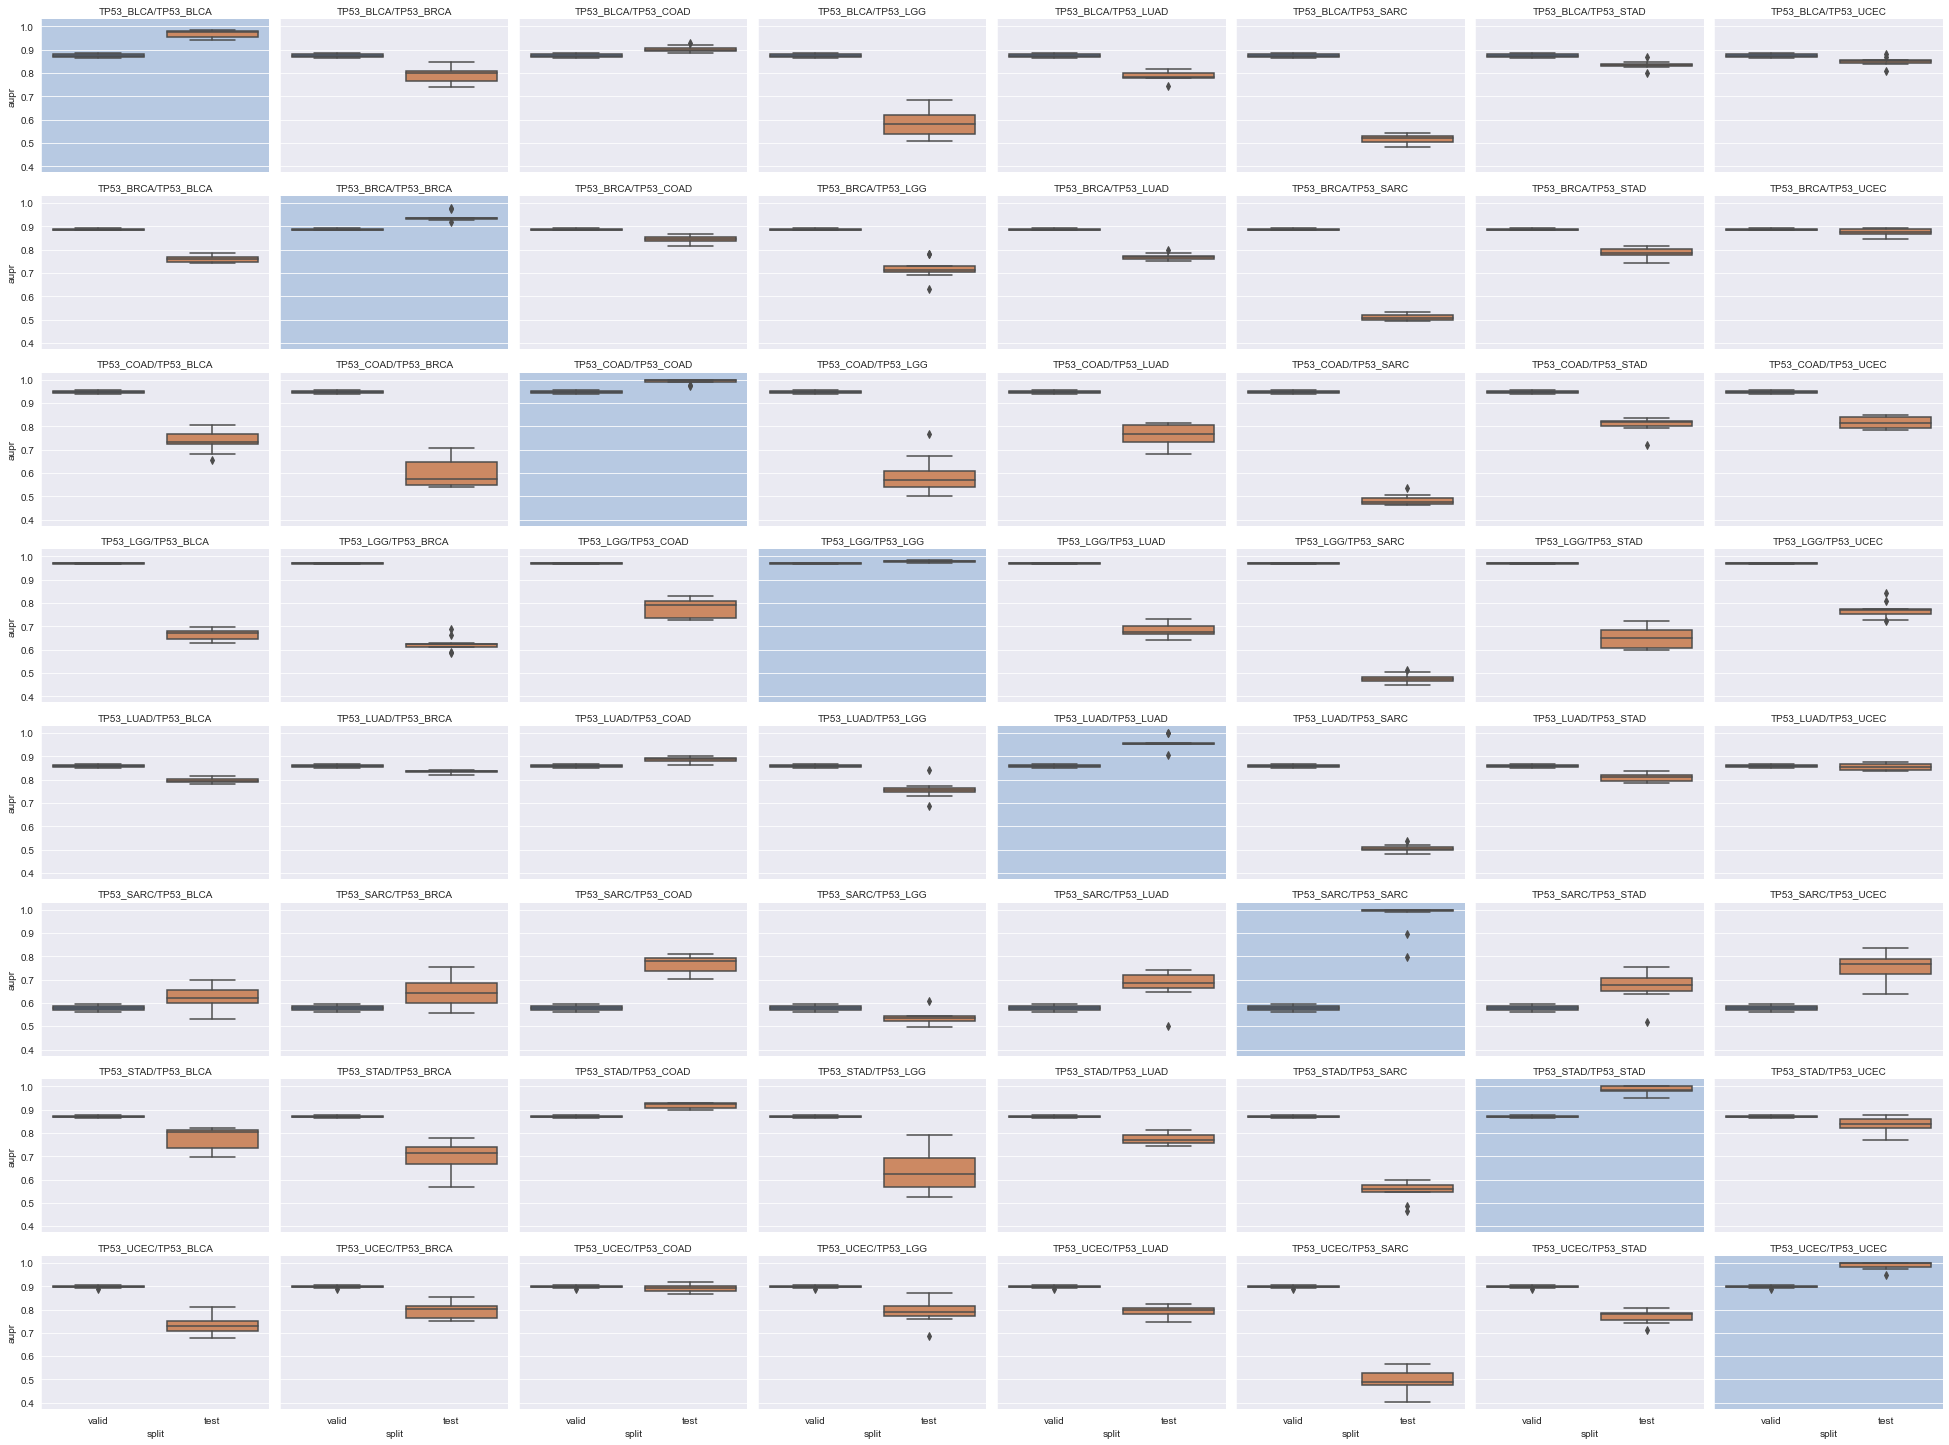

In [9]:
g = sns.catplot(
    data=plot_big_df,
    x='split', y='aupr', col='identifiers', kind='box', col_wrap=8,
    height=2.5, aspect=1.35
)
g.set_titles(col_template='{col_name}')

num_ids = len(plot_big_df.train_identifier.unique())
for row in range(num_ids):
    diag_ix = (num_ids * row) + row
    g.axes[diag_ix].set_facecolor('xkcd:light blue grey')

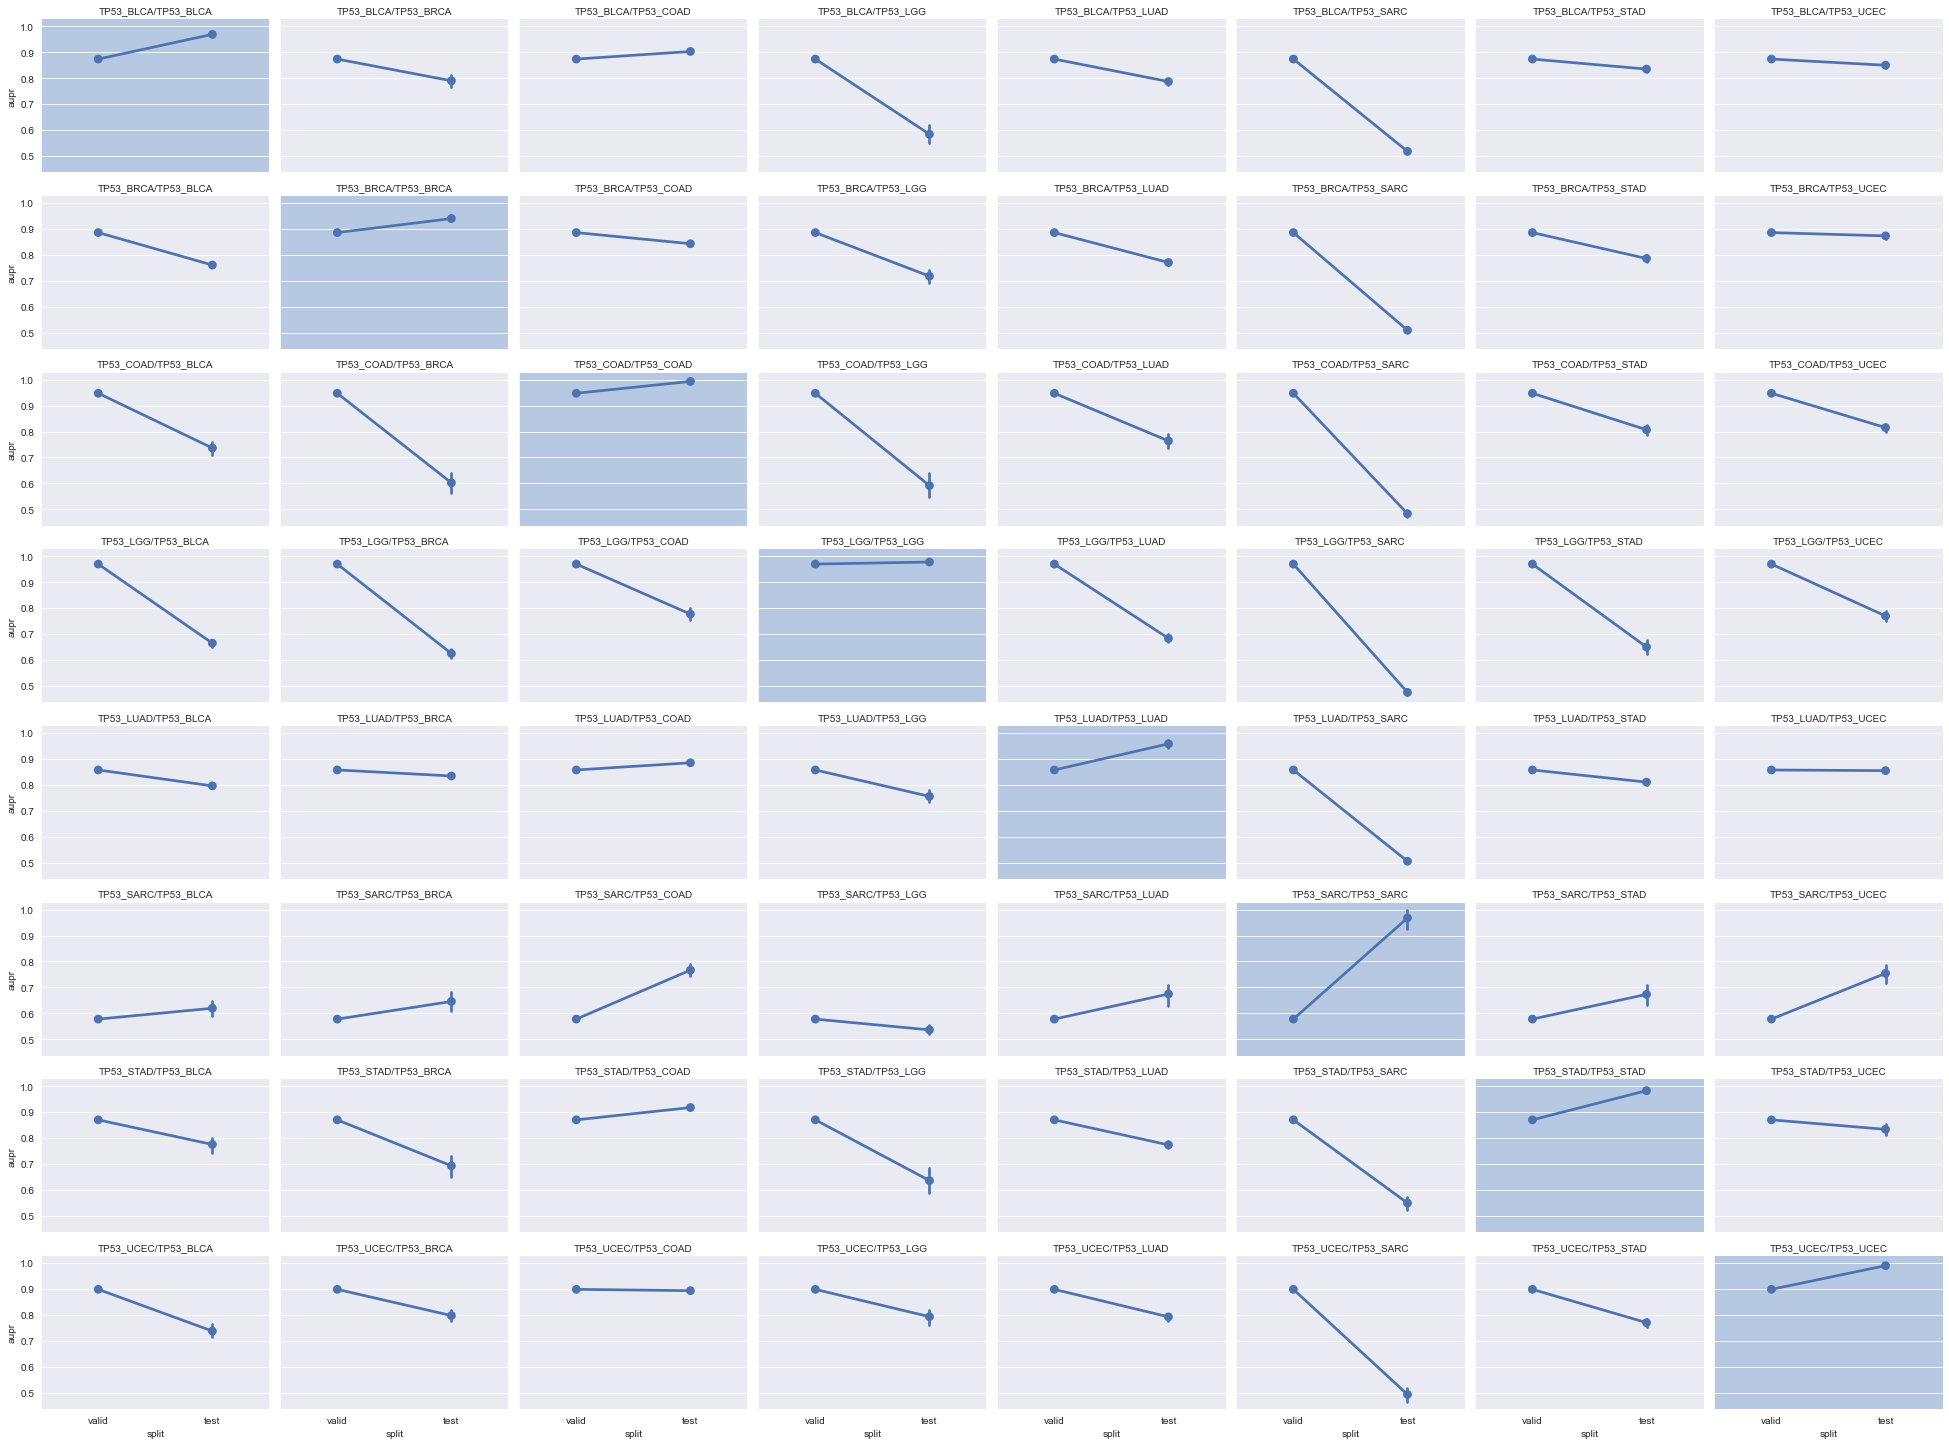

In [10]:
g = sns.catplot(
    data=plot_big_df,
    x='split', y='aupr', col='identifiers', kind='point', col_wrap=8,
    height=2.5, aspect=1.35
)
g.set_titles(col_template='{col_name}')
num_ids = len(plot_big_df.train_identifier.unique())
for row in range(num_ids):
    diag_ix = (num_ids * row) + row
    g.axes[diag_ix].set_facecolor('xkcd:light blue grey')

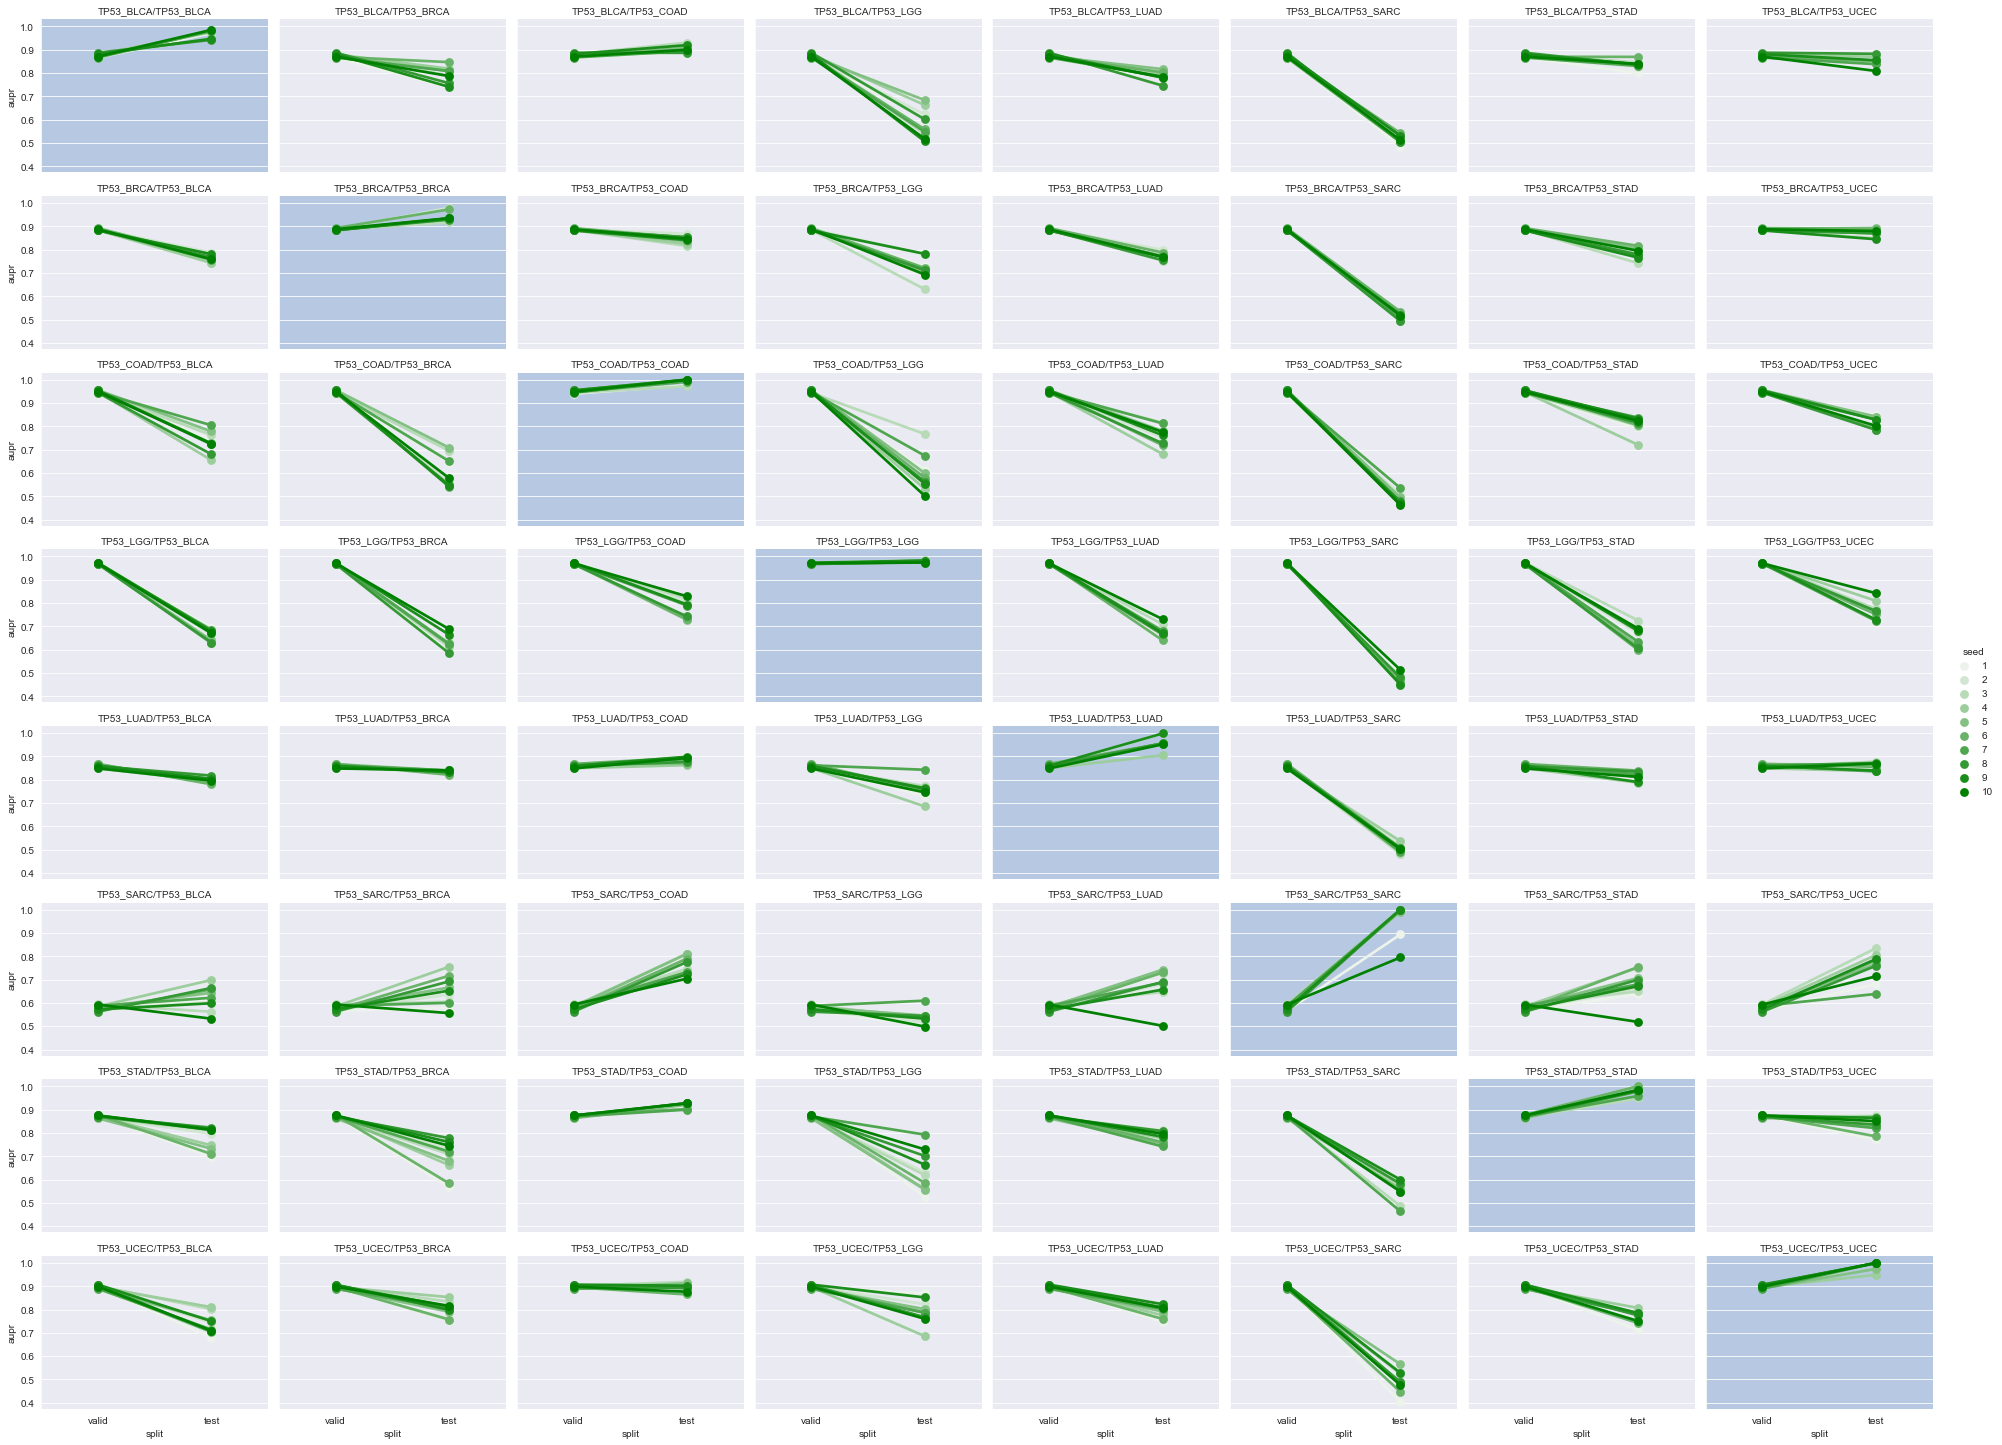

In [11]:
g = sns.catplot(
    data=plot_big_df,
    x='split', y='aupr', col='identifiers', kind='point', hue='seed', col_wrap=8,
    color='green', ci=None, height=2.5, aspect=1.35
)
g.set_titles(col_template='{col_name}')
num_ids = len(plot_big_df.train_identifier.unique())
for row in range(num_ids):
    diag_ix = (num_ids * row) + row
    g.axes[diag_ix].set_facecolor('xkcd:light blue grey')